## Importing the relevant libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import seaborn as sns
sns.set()

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

# loading data from postgreSQL database 
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices', con=engine)
# no need for an open connection as we are only doing a single query 
engine.dispose()

## Loading the raw data

In [2]:
df.head(5)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


## Preprocessing

### Exploring the descriptive statistics of the variables

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [4]:
df.describe(include='all')

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
count,1460.000,1460.000,1460,1201.000,1460.000,1460,91,1460,1460,1460,...,1460.000,7,281,54,1460.000,1460.000,1460.000,1460,1460,1460.000
unique,nan,nan,5,nan,nan,2,2,4,4,2,...,nan,3,4,4,nan,nan,nan,9,6,nan
top,nan,nan,RL,nan,nan,Pave,Grvl,Reg,Lvl,AllPub,...,nan,Gd,MnPrv,Shed,nan,nan,nan,WD,Normal,nan
freq,nan,nan,1151,nan,nan,1454,50,925,1311,1459,...,nan,3,157,49,nan,nan,nan,1267,1198,nan
mean,730.500,56.897,NaN,70.050,10516.828,NaN,NaN,NaN,NaN,NaN,...,2.759,NaN,NaN,NaN,43.489,6.322,2007.816,NaN,NaN,180921.196
std,421.610,42.301,NaN,24.285,9981.265,NaN,NaN,NaN,NaN,NaN,...,40.177,NaN,NaN,NaN,496.123,2.704,1.328,NaN,NaN,79442.503
min,1.000,20.000,NaN,21.000,1300.000,NaN,NaN,NaN,NaN,NaN,...,0.000,NaN,NaN,NaN,0.000,1.000,2006.000,NaN,NaN,34900.000
25%,365.750,20.000,NaN,59.000,7553.500,NaN,NaN,NaN,NaN,NaN,...,0.000,NaN,NaN,NaN,0.000,5.000,2007.000,NaN,NaN,129975.000
50%,730.500,50.000,NaN,69.000,9478.500,NaN,NaN,NaN,NaN,NaN,...,0.000,NaN,NaN,NaN,0.000,6.000,2008.000,NaN,NaN,163000.000
75%,1095.250,70.000,NaN,80.000,11601.500,NaN,NaN,NaN,NaN,NaN,...,0.000,NaN,NaN,NaN,0.000,8.000,2009.000,NaN,NaN,214000.000


## Data Wrangling

### Checking for missing values

In [5]:
total_missing = df.isnull().sum().sort_values(ascending=False)
percent_missing = (df.isnull().mean()*100).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
poolqc,1453,99.521
miscfeature,1406,96.301
alley,1369,93.767
fence,1179,80.753
fireplacequ,690,47.260
lotfrontage,259,17.740
garagecond,81,5.548
garagetype,81,5.548
garageyrblt,81,5.548
garagefinish,81,5.548


Only 19 of the features have missing values. Since there are many other features with non-missing values that can be used towards predicting house prices, we won't be doing anything here.

### Determining the variables of interest

One way to choose a good predictor is by looking at the correlations between the possible feature variables and the target variable:

In [6]:
numeric_cols = df.select_dtypes(['int64', 'float64']).columns

# deriving correaltions of the features with out target variable irrespective of their signs by taking absolute values
np.abs(df[numeric_cols].iloc[:, 1:].corr().loc[:,'saleprice']).sort_values(ascending=False)

saleprice       1.000
overallqual     0.791
grlivarea       0.709
garagecars      0.640
garagearea      0.623
totalbsmtsf     0.614
firstflrsf      0.606
fullbath        0.561
totrmsabvgrd    0.534
yearbuilt       0.523
yearremodadd    0.507
garageyrblt     0.486
masvnrarea      0.477
fireplaces      0.467
bsmtfinsf1      0.386
lotfrontage     0.352
wooddecksf      0.324
secondflrsf     0.319
openporchsf     0.316
halfbath        0.284
lotarea         0.264
bsmtfullbath    0.227
bsmtunfsf       0.214
bedroomabvgr    0.168
kitchenabvgr    0.136
enclosedporch   0.129
screenporch     0.111
poolarea        0.092
mssubclass      0.084
overallcond     0.078
mosold          0.046
threessnporch   0.045
yrsold          0.029
lowqualfinsf    0.026
miscval         0.021
bsmthalfbath    0.017
bsmtfinsf2      0.011
Name: saleprice, dtype: float64

`overallqual` has the highest correlation with `saleprice`- something to keep in mind.

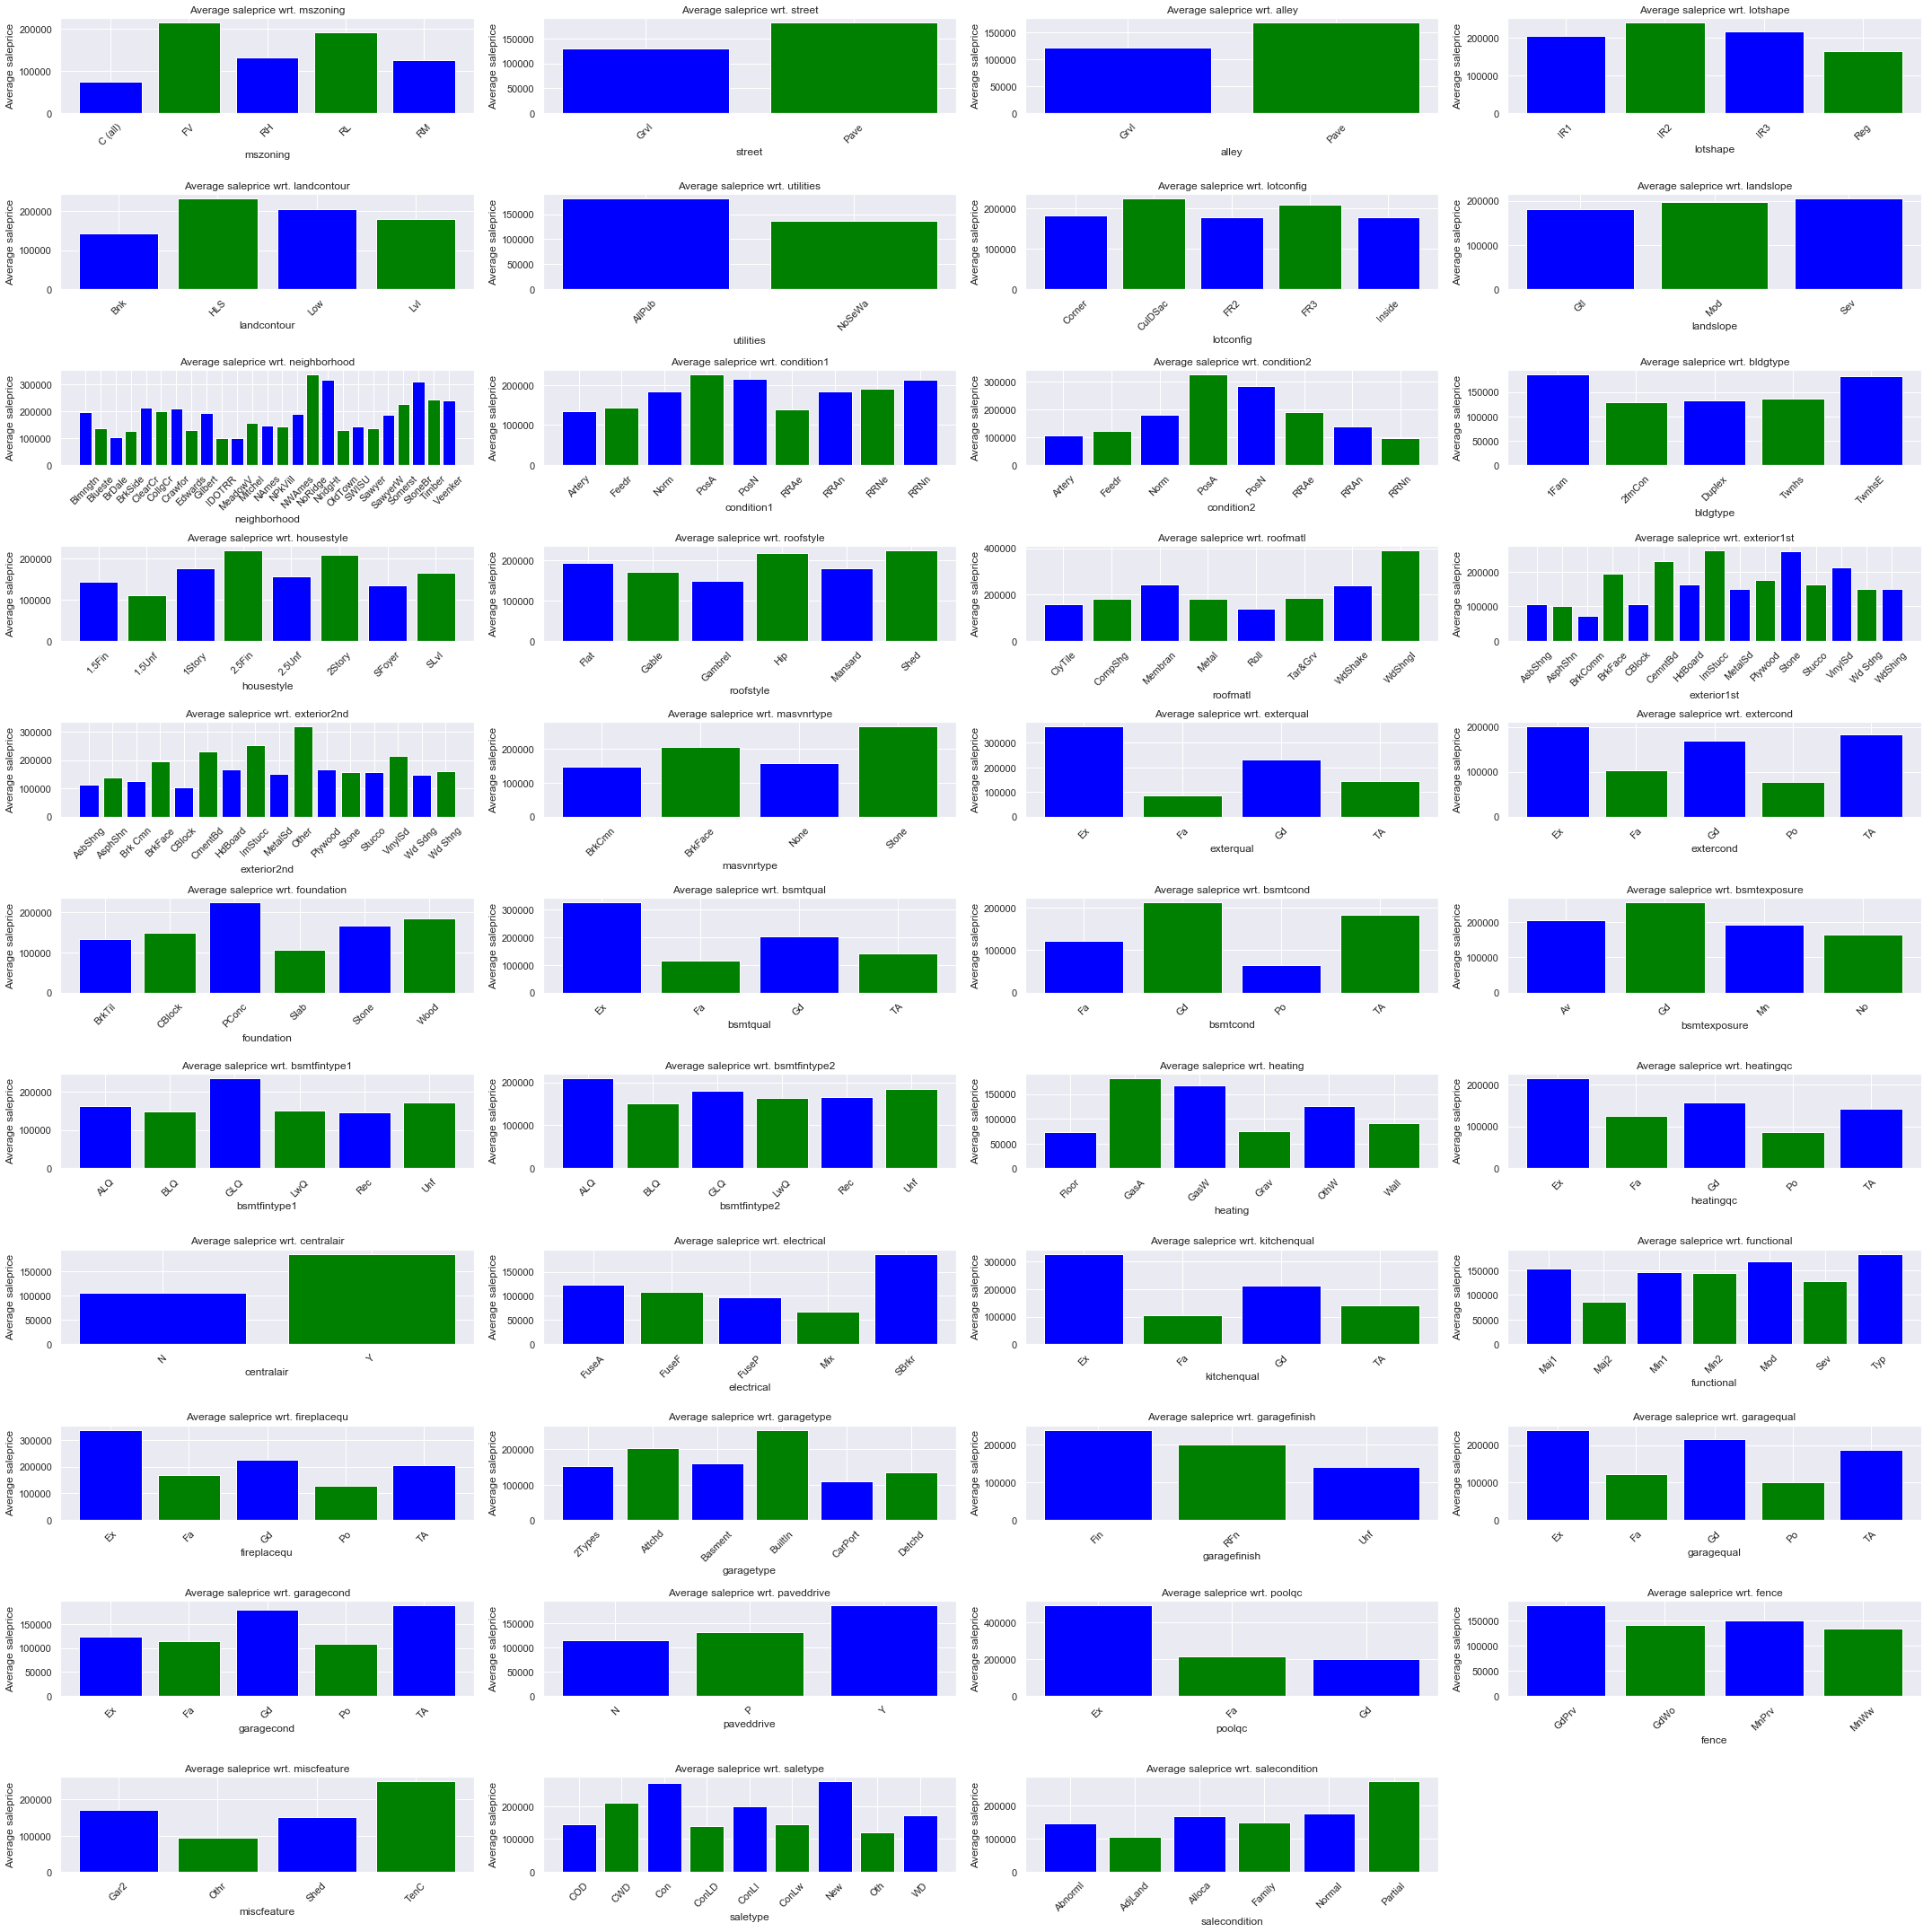

In [7]:
classification_cols = df.select_dtypes(['object']).columns

plt.figure(figsize=(30,30))

for i, column in enumerate(classification_cols):
    plt.subplot(11,4,i+1)
    plt.bar(df.groupby(column)['saleprice'].mean().index, df.groupby(column)['saleprice'].mean(), color=['blue', 'green'])
    plt.title('Average saleprice wrt. {}'.format(column))
    plt.ylabel('Average saleprice')
    plt.xlabel(column)
    plt.xticks(rotation='45')
plt.tight_layout()
plt.show()


Our aim is to predict `saleprice` of the houses, and to do that, we'll choose `lotarea`, `mszoning`, `street`, `garagearea`, `bldgtype`, `overallqual`, `utilities`, and `centralair` as our predictors.

We will also add `yrsold` for the sole purpose of incorporating outside datasets later:

In [8]:
# creating a new dataframe with our dependent and independent variables
df1 = df[['saleprice', 'lotarea', 'mszoning', 'street', 'garagearea', 'bldgtype', 'overallqual', 'utilities', 'centralair', 'yrsold']]
df1.head()

,saleprice,lotarea,mszoning,street,garagearea,bldgtype,overallqual,utilities,centralair,yrsold
0,208500,8450,RL,Pave,548,1Fam,7,AllPub,Y,2008
1,181500,9600,RL,Pave,460,1Fam,6,AllPub,Y,2007
2,223500,11250,RL,Pave,608,1Fam,7,AllPub,Y,2008
3,140000,9550,RL,Pave,642,1Fam,7,AllPub,Y,2006
4,250000,14260,RL,Pave,836,1Fam,8,AllPub,Y,2008


In [9]:
df1.describe(include='all')

,saleprice,lotarea,mszoning,street,garagearea,bldgtype,overallqual,utilities,centralair,yrsold
count,1460.000,1460.000,1460,1460,1460.000,1460,1460.000,1460,1460,1460.000
unique,nan,nan,5,2,nan,5,nan,2,2,nan
top,nan,nan,RL,Pave,nan,1Fam,nan,AllPub,Y,nan
freq,nan,nan,1151,1454,nan,1220,nan,1459,1365,nan
mean,180921.196,10516.828,NaN,NaN,472.980,NaN,6.099,NaN,NaN,2007.816
std,79442.503,9981.265,NaN,NaN,213.805,NaN,1.383,NaN,NaN,1.328
min,34900.000,1300.000,NaN,NaN,0.000,NaN,1.000,NaN,NaN,2006.000
25%,129975.000,7553.500,NaN,NaN,334.500,NaN,5.000,NaN,NaN,2007.000
50%,163000.000,9478.500,NaN,NaN,480.000,NaN,6.000,NaN,NaN,2008.000
75%,214000.000,11601.500,NaN,NaN,576.000,NaN,7.000,NaN,NaN,2009.000


There is no missing value in our chosen features so we can proceed at ease.

Since categorical variables mszoning, street, bldgtype, overallqual, utilities and centralair are strings, we need to convert them to numeric values, using one_hot_encoding.

In [10]:
# get dummies for categorical variables
df1 = pd.concat([df1, pd.get_dummies(df1.mszoning, drop_first=True)], axis=1)
df1 = pd.concat([df1, pd.get_dummies(df1.street, drop_first=True)], axis=1)
df1 = pd.concat([df1, pd.get_dummies(df1.overallqual, drop_first=True)], axis=1)
df1 = pd.concat([df1, pd.get_dummies(df1.bldgtype, drop_first=True)], axis=1)
df1 = pd.concat([df1, pd.get_dummies(df1.utilities, drop_first=True)], axis=1)
df1 = pd.concat([df1, pd.get_dummies(df1.centralair, drop_first=True)], axis=1)
df1.columns

Index([  'saleprice',     'lotarea',    'mszoning',      'street',
        'garagearea',    'bldgtype', 'overallqual',   'utilities',
        'centralair',      'yrsold',          'FV',          'RH',
                'RL',          'RM',        'Pave',             2,
                   3,             4,             5,             6,
                   7,             8,             9,            10,
            '2fmCon',      'Duplex',       'Twnhs',      'TwnhsE',
            'NoSeWa',           'Y'],
      dtype='object')

In [11]:
# Y is the target
Y = df1.saleprice

# X is the feature set
X = df1[['lotarea',  'garagearea',          'FV',          'RH',
              'RL',          'RM',        'Pave',             2,
                 3,             4,             5,             6,
                 7,             8,             9,            10,
           'Twnhs',      'TwnhsE',      'NoSeWa',           'Y']]

# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# setting constant
X_train = sm.add_constant(X_train)

# fitting OLS
results = sm.OLS(y_train, X_train).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     169.1
Date:                Wed, 07 Aug 2019   Prob (F-statistic):               0.00
Time:                        09:00:32   Log-Likelihood:                -14012.
No. Observations:                1168   AIC:                         2.807e+04
Df Residuals:                    1147   BIC:                         2.817e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.618e+04   3.69e+04     -0.979      0.3

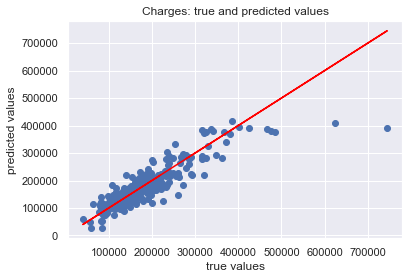

Mean absolute error of the prediction is: 26687.98461611541
Mean squared error of the prediction is: 1646700478.699667
Root mean squared error of the prediction is: 40579.55739901148
Mean absolute percentage error of the prediction is: 15.32052884264911


In [12]:
# setting constant
X_test = sm.add_constant(X_test)

# making prediction
y_test_preds = results.predict(X_test)

plt.scatter(y_test, y_test_preds)
plt.plot(y_test, y_test, color='red')
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_test_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_preds) / y_test)) * 100))

* R-squared and Adj. R-squared are 0.747 and 0.742 respectively, indicating our model is unable to predict 25.8% of the target variance.
* F statistic and its associated p-value are 169.1 and 0.00 respectively.
* AIC and BIC of the model are 2807 and 2817 respectively.
* In the graph, we see that our model predicts the lower values of the target better than the higher values. 

#### We'll make the following changes:

* Removing statistically insignificant coefficients as they won't affect our model too much
* Checking for outliers
* Transforming our variables if they are not normally distributed
* Adding an interaction between `lotarea` and `overallqual`

### Dealing with outliers

#### Saleprice
First, let's look at the distribution of the target variable `saleprice`.

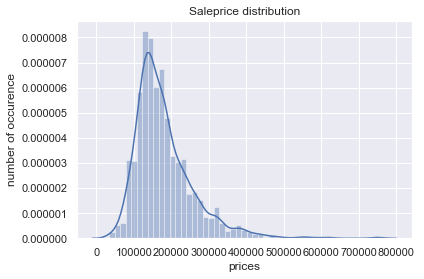

In [13]:
sns.distplot(df1.saleprice)
plt.title('Saleprice distribution')
plt.xlabel('prices')
plt.ylabel('number of occurence')
plt.show()

Obviously there are some outliers present. Outliers are a great issue for OLS, thus we must deal with them in some ways.
In this case, `saleprice` is exponentially distributed so we can log transform it.

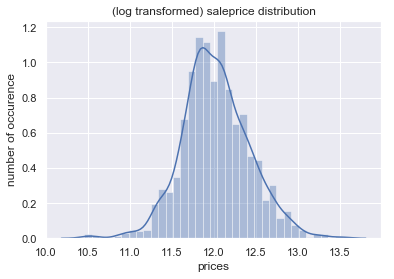

In [14]:
log_price = np.log1p(df1.saleprice)

df1['log_price'] = log_price

sns.distplot(df1.log_price)
plt.title('(log transformed) saleprice distribution')
plt.xlabel('prices')
plt.ylabel('number of occurence')
plt.show()

`saleprice` now looks more normally distributed. 

Let's move on with the feature variables:
#### Lotarea

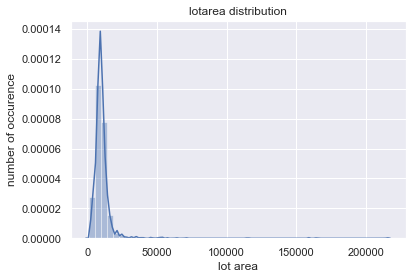

In [15]:
sns.distplot(df1.lotarea)
plt.title('lotarea distribution')
plt.xlabel('lot area')
plt.ylabel('number of occurence')
plt.show()

`lotarea` is extremely right-skewed. We'll winsorize it:

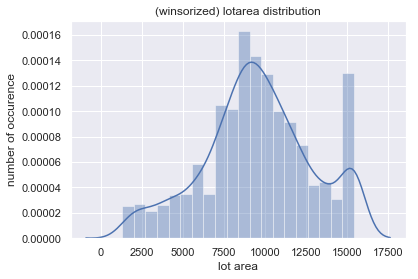

In [16]:
df1['w_lot'] = winsorize(df1.lotarea, (0,0.08))
sns.distplot(df1.w_lot)
plt.title('(winsorized) lotarea distribution')
plt.xlabel('lot area')
plt.ylabel('number of occurence')
plt.show()

`lotarea` now looks less skewed. Next is:

#### Garagearea

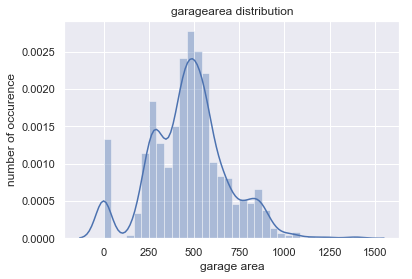

In [17]:
sns.distplot(df1.garagearea)
plt.title('garagearea distribution')
plt.xlabel('garage area')
plt.ylabel('number of occurence')
plt.show()

`garagaarea` looks slightly skewed to the right, so we will just remove any outliers that above the 99.5 perccentile.

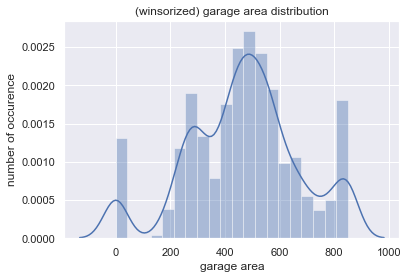

In [18]:
df1['w_garage'] = winsorize(df1.garagearea, (0,0.05))
sns.distplot(df1.w_garage)
plt.title('(winsorized) garage area distribution')
plt.xlabel('garage area')
plt.ylabel('number of occurence')
plt.show()

In [19]:
df1 = df1.reset_index(drop=True)
df1.describe(include='all')

,saleprice,lotarea,mszoning,street,garagearea,bldgtype,overallqual,utilities,centralair,yrsold,...,10,2fmCon,Duplex,Twnhs,TwnhsE,NoSeWa,Y,log_price,w_lot,w_garage
count,1460.000,1460.000,1460,1460,1460.000,1460,1460.000,1460,1460,1460.000,...,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000
unique,nan,nan,5,2,nan,5,nan,2,2,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,nan,nan,RL,Pave,nan,1Fam,nan,AllPub,Y,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,nan,nan,1151,1454,nan,1220,nan,1459,1365,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,180921.196,10516.828,NaN,NaN,472.980,NaN,6.099,NaN,NaN,2007.816,...,0.012,0.021,0.036,0.029,0.078,0.001,0.935,12.024,9510.601,468.183
std,79442.503,9981.265,NaN,NaN,213.805,NaN,1.383,NaN,NaN,1.328,...,0.110,0.144,0.185,0.169,0.268,0.026,0.247,0.399,3322.915,202.055
min,34900.000,1300.000,NaN,NaN,0.000,NaN,1.000,NaN,NaN,2006.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,10.460,1300.000,0.000
25%,129975.000,7553.500,NaN,NaN,334.500,NaN,5.000,NaN,NaN,2007.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,11.775,7553.500,334.500
50%,163000.000,9478.500,NaN,NaN,480.000,NaN,6.000,NaN,NaN,2008.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,12.002,9478.500,480.000
75%,214000.000,11601.500,NaN,NaN,576.000,NaN,7.000,NaN,NaN,2009.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,12.274,11601.500,576.000


## Regression Model

In [20]:
Y = df1.log_price

# adding interaction between garagearea and overallqual
df1['quality_lot'] = df1.w_lot * df1.w_garage

# X is the feature set after removing statistically insignificant coefficient variables
X = df1[[  'w_lot',      'w_garage',          'FV',          'RH',
              'RL',               6,             7,             8,            
                 9,              10,       'Twnhs',      'TwnhsE',          
               'Y',   'quality_lot']]

# splitting
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=1)

# setting constant
X_train = sm.add_constant(X_train)

# fitting OLS
results = sm.OLS(y_train, X_train).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     282.7
Date:                Wed, 07 Aug 2019   Prob (F-statistic):               0.00
Time:                        09:00:33   Log-Likelihood:                 291.71
No. Observations:                1168   AIC:                            -553.4
Df Residuals:                    1153   BIC:                            -477.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          11.0175      0.048    231.692      

* R-squared and Adj. R-squared went up to 0.772 and 0.770 respectively, indicating improved predictive power after `saleprice`, `garagearea` and `lotarea` got transformed.


* However, high P-value means `quality_lot` doesn't contribute anything to our model, so we'll remove it along with `Twnhs` before checking how well our model fits the test set.

In [21]:
Y = df1.log_price

# X is the feature set after removing statistically insignificant coefficient variables
X = df1[[  'w_lot',      'w_garage',          'FV',          'RH',
              'RL',               6,             7,             8,            
                 9,              10,      'TwnhsE',           'Y']]

# splitting
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=1)

# setting constant
X_train = sm.add_constant(X_train)

# fitting OLS
results = sm.OLS(y_train, X_train).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     330.3
Date:                Wed, 07 Aug 2019   Prob (F-statistic):               0.00
Time:                        09:00:33   Log-Likelihood:                 291.63
No. Observations:                1168   AIC:                            -557.3
Df Residuals:                    1155   BIC:                            -491.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0316      0.028    395.670      0.0

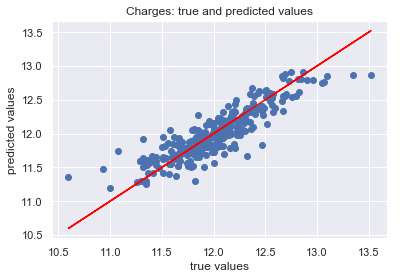

Mean absolute error of the prediction is: 0.14864557169134415
Mean squared error of the prediction is: 0.039139917866520886
Root mean squared error of the prediction is: 0.19783811024805328
Mean absolute percentage error of the prediction is: 1.2409266357652218


In [22]:
# setting constant
X_test = sm.add_constant(X_test)

# making prediction
y_test_preds = results.predict(X_test)

plt.scatter(y_test, y_test_preds)
plt.plot(y_test, y_test, color='red')
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_test_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_preds) / y_test)) * 100))

* R-squared and Adj. R-squared are 0.772 and 0.770 respectively.
* F statistic and its associated p-value are 330.3 and 0.00 respectively.
* AIC and BIC of the model went down to -557.3 and -491.4 respectively.
* MAE, MSE, RMSE, and MAPE also decrease compared to the previous ones, indicating better predictive power. For every metric, the second model achieves a better prediction performance in the test set. 

## Checking for overfitting

In [23]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)

y_train_preds = lrm.predict(X_train)
y_test_preds = lrm.predict(X_test)

print('R-squared of the model in the training set is: {}'.format(lrm.score(X_train, y_train)))
print('----------------------------------------------------------------------------------------------------------------------')
print('R-squared of the model in the test set is: {}'.format(lrm.score(X_test, y_test)))

R-squared of the model in the training set is: 0.7743719703975217
----------------------------------------------------------------------------------------------------------------------
R-squared of the model in the test set is: 0.765827317558694


As we can see, R-squared value of the model in the training set is 0.774, whereas in the test set is 0.766. Since the generalization gap between our training and test sets is quite small, our Linear Regression model actually fits the training set pretty well. 

Let's try a few other models to see if there is a better performing one:

### Ridge regression

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

alphas = [np.power(10.0,p) for p in np.arange(-10,50,1)]

# cv=5 makes a KFold inner splitting with 5 folds
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# making prediction
y_train_preds = ridge_cv.predict(X_train)
y_test_preds = ridge_cv.predict(X_test)

print('Best alpha value is {}'.format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_test_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_preds) / y_test)) * 100))

Best alpha value is 0.1
R-squared of the model in training set is: 0.774365625257713
-----Test set statistics-----
R-squared of the model in test set is: 0.7652502740514857
Mean absolute error of the prediction is: 0.14869961961748973
Mean squared error of the prediction is: 0.039236365647030085
Root mean squared error of the prediction is: 0.1980817145700988
Mean absolute percentage error of the prediction is: 1.2413026738855406


### Lasso regression

In [25]:
alphas = [np.power(10.0,p) for p in np.arange(-10,50,1)]

# cv=5 makes a KFold inner splitting with 5 folds
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

# making prediction
y_train_preds = lasso_cv.predict(X_train)
y_test_preds = lasso_cv.predict(X_test)

print('Best alpha value is {}'.format(lasso_cv.alpha_))
print('R-squared of the model on the training set is: {}'.format(lasso_cv.score(X_train, y_train)))
print('---------Test set statistic--------------')
print('R-squared of the model on the test set is: {}'.format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_test_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_preds) / y_test)) * 100))

Best alpha value is 0.0001
R-squared of the model on the training set is: 0.7743428026691997
---------Test set statistic--------------
R-squared of the model on the test set is: 0.764896061949923
Mean absolute error of the prediction is: 0.14871222168703788
Mean squared error of the prediction is: 0.03929556910499948
Root mean squared error of the prediction is: 0.19823110024665525
Mean absolute percentage error of the prediction is: 1.2413816825243011


### ElasticNet regression

In [26]:
alphas = [np.power(10.0,p) for p in np.arange(-10,50,1)]

# cv=5 makes KFold inner splitting with 5 folds
elastic_cv = ElasticNetCV(alphas=alphas, cv=5)
elastic_cv.fit(X_train, y_train)

# making prediction
y_train_preds = elastic_cv.predict(X_train)
y_test_preds = elastic_cv.predict(X_test)

print('Best alpha value is {}'.format(elastic_cv.alpha_))
print("R-squared of the model on the training set is: {}".format(elastic_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elastic_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_test_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_test_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_test_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_preds) / y_test)) * 100))

Best alpha value is 0.0001
R-squared of the model on the training set is: 0.7743557782782907
-----Test set statistics-----
R-squared of the model on the test set is: 0.7650275147431826
Mean absolute error of the prediction is: 0.1487103155314978
Mean squared error of the prediction is: 0.03927359791912985
Root mean squared error of the prediction is: 0.19817567438797792
Mean absolute percentage error of the prediction is: 1.2413727604477067


* Comparing across all the R-squared values on the training versus test sets, along with the MAE, MSE, RMSE, and MAPE values show that our **Linear regression** is the best model.

## Adding outside factors

According to FRED (Federal Reserve Economic Data), some of the key factors which affect property prices are: supply and demand, interest rate, economic growth, demographics, location, etc. 

For this feature engineering process, we will incorporate the interest rate and GDP growth rate to see if they help predicting house prices better. 

Average US mortgage interest rates from 2006 to 2010 are taken from [FreddieMac](http://www.freddiemac.com/pmms/pmms30.html) and US GDP growth rates from 2006 to 2010 are taken from [the balance](https://www.thebalance.com/us-gdp-by-year-3305543) websites:

In [27]:
df1.yrsold.unique()

array([2008, 2007, 2006, 2009, 2010], dtype=int64)

In [28]:
# making a new interest_rate dataframe
interest_rate = pd.DataFrame([[6.41], [6.34], [6.03], [5.04], [4.69]], columns=['%_interest_rate'])
interest_rate['yrsold'] = [2006, 2007, 2008, 2009, 2010]
interest_rate

,%_interest_rate,yrsold
0,6.410,2006
1,6.340,2007
2,6.030,2008
3,5.040,2009
4,4.690,2010


In [29]:
# making a new gdp_growth_rate dataframe
gdp_growth_rate = pd.DataFrame([[2.90], [1.90], [-0.10], [-2.50], [2.60]], columns=['gdp_growth_rate'])
gdp_growth_rate['yrsold'] = [2006, 2007, 2008, 2009, 2010]
gdp_growth_rate

,gdp_growth_rate,yrsold
0,2.900,2006
1,1.900,2007
2,-0.100,2008
3,-2.500,2009
4,2.600,2010


In [30]:
# adding %_interest_rate and gdp_growth_rate to df1 dataframe
df1['%_interest_rate'] = df1['yrsold'].map(interest_rate.set_index('yrsold')['%_interest_rate'])
df1['gdp_growth_rate'] = df1['yrsold'].map(gdp_growth_rate.set_index('yrsold')['gdp_growth_rate'])

df1.head()

,saleprice,lotarea,mszoning,street,garagearea,bldgtype,overallqual,utilities,centralair,yrsold,...,Twnhs,TwnhsE,NoSeWa,Y,log_price,w_lot,w_garage,quality_lot,%_interest_rate,gdp_growth_rate
0,208500,8450,RL,Pave,548,1Fam,7,AllPub,Y,2008,...,0,0,0,1,12.248,8450,548,4630600,6.030,-0.100
1,181500,9600,RL,Pave,460,1Fam,6,AllPub,Y,2007,...,0,0,0,1,12.109,9600,460,4416000,6.340,1.900
2,223500,11250,RL,Pave,608,1Fam,7,AllPub,Y,2008,...,0,0,0,1,12.317,11250,608,6840000,6.030,-0.100
3,140000,9550,RL,Pave,642,1Fam,7,AllPub,Y,2006,...,0,0,0,1,11.849,9550,642,6131100,6.410,2.900
4,250000,14260,RL,Pave,836,1Fam,8,AllPub,Y,2008,...,0,0,0,1,12.429,14260,836,11921360,6.030,-0.100


In [31]:
# get dummies for interest_rate variables
df1 = pd.concat([df1, pd.get_dummies(df1['%_interest_rate'], drop_first=True)], axis=1)
# get dummies for gdp_growth_rate variables
df1 = pd.concat([df1, pd.get_dummies(df1['gdp_growth_rate'], drop_first=True)], axis=1)

In [32]:
Y = df1.log_price

# X is the feature set taken from the chosen model above plus interest_rate and gdp_growth_rate dummies
X = df1[[  'w_lot',      'w_garage',          'FV',          'RH',
              'RL',               6,             7,             8,            
                 9,              10,      'TwnhsE',           'Y',
              5.04,            6.03,          6.34,          6.41,
              -0.1,             1.9,           2.6,           2.9]]

# splitting
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=1)

# setting constant
X_train = sm.add_constant(X_train)

# fitting OLS
results = sm.OLS(y_train, X_train).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     247.8
Date:                Wed, 07 Aug 2019   Prob (F-statistic):               0.00
Time:                        09:00:35   Log-Likelihood:                 293.20
No. Observations:                1168   AIC:                            -552.4
Df Residuals:                    1151   BIC:                            -466.3
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5794      0.022    393.145      0.0

In [33]:
Y = df1.log_price

X = df1[[  'w_lot',      'w_garage',          'FV',          'RH',
              'RL',               6,             7,             8,            
                 9,              10,      'TwnhsE',           'Y',
              5.04,            6.03,          6.34,          6.41,
              -0.1,             1.9,           2.6,           2.9]]

# splitting
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=1)

lrm = LinearRegression()
lrm.fit(X_train, y_train)

# making predictions
y_train_preds = lrm.predict(X_train)
y_test_preds = lrm.predict(X_test)

print('R-squared of the model in the training set is: {}'.format(lrm.score(X_train, y_train)))
print('--------Test set statistics------------')
print('R-squared of the model in the test set is: {}'.format(lrm.score(X_test, y_test)))
print('Mean absolute error of the prediction is: {}'.format(mean_absolute_error(y_test, y_test_preds)))
print('Mean squared error of the prediction is: {}'.format(mse(y_test, y_test_preds)))
print('Root mean squared error of the prediction is: {}'.format(rmse(y_test, y_test_preds)))
print('Mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((y_test - y_test_preds)/y_test))*100))

R-squared of the model in the training set is: 0.7749784232594826
--------Test set statistics------------
R-squared of the model in the test set is: 0.766509974949901
Mean absolute error of the prediction is: 0.14883191880499047
Mean squared error of the prediction is: 0.03902581764806477
Root mean squared error of the prediction is: 0.19754953213830898
Mean absolute percentage error of the prediction is: 1.2427291488900265


* R-squared and Adj. R-squared of the training set, and R-squared of the test set increase slightly to 0.775, 0.772, and 0.767 respectively, indicating improved predictive power after adding outside factors `%_interest_rate` and `gdp_growth_rate`.
* F statistic and its associated p-value are 247.8 and 0.00.
* AIC and BIC of the model went down to -552.4 and -466.3 respectively.
* MAE, MSE, RMSE, and MAPE also decrease compared to the previous model without additional outside factors. 
* For every metric, despite the small improvements, we can tell that the additional outside factors help to improve our model and its prediction power.